<a href="https://colab.research.google.com/github/salmanromeo/1D_Pitching_Moment/blob/main/PINN_Multi_Input_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [60]:
# Libraries
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

In [61]:
# Defines the analytical solution
def oscillator(A, ro, v, s, d, CM_q_a, CM_a, I, phi, t):
    w = np.sqrt(-((ro*v**2*s*d*CM_a)/(2*I)))
    cos = torch.cos(w*t + phi)
    e = (ro*v*s*d**2)*(CM_q_a)/(8*I)
    exp = torch.exp(e*t)
    y = A*exp*cos
    return y

In [62]:
# Defines a standard fully-connected network in PyTorch
class FCN(nn.Module):
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.Tanh
        self.fcs = nn.Sequential(*[
                        nn.Linear(N_INPUT, N_HIDDEN),
                        activation()])
        self.fch = nn.Sequential(*[
                        nn.Sequential(*[
                            nn.Linear(N_HIDDEN, N_HIDDEN),
                            activation()]) for _ in range(N_LAYERS-1)])
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)
        
    def forward(self, x1, x2):
        x = torch.cat([x1, x2], dim=1)
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x

In [63]:
# Assign parameters
A       = 1
ro      = 1.20
v       = 858
c       = 343.2
s       = 0.00385
d       = 0.07
CM_a    = -0.09
I       = 1.55e-4
phi     = 0
mach    = v/c
cm_q_a = np.array([-0.4, -0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5])

torch.Size([3000, 1]) torch.Size([3000, 1]) torch.Size([1500, 1]) torch.Size([1500, 1])


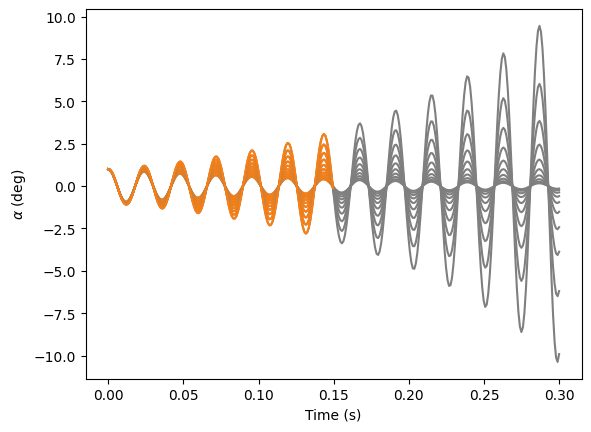

In [64]:
# Generate training data
t = torch.linspace(0,0.3,300).view(-1,1)
y_s = []
t_s = []
y_data = []
t_data = []
for i in range(len(cm_q_a)):
    y = oscillator(A, ro, v, s, d, cm_q_a[i], CM_a, I, phi, t).view(-1,1)
    plt.plot(t, y, label="Exact solution", color="tab:grey")
    plt.xlabel("Time (s)")
    plt.ylabel(r'$\alpha$ (deg)')
    y_data_s = y[0:150:1]
    t_data_s = t[0:150:1]
    plt.plot(t_data_s, y_data_s, color="tab:orange", label="Training data")
    #plt.legend(loc=(1.01,0.34))
    #plt.show()
    y_s.append(y)
    t_s.append(t)
    y_data.append(y_data_s)
    t_data.append(t_data_s)

y_s = torch.cat(y_s, dim=0)
t_s = torch.cat(t_s, dim=0)
y_data = torch.cat(y_data, dim=0)
t_data = torch.cat(t_data, dim=0)
print(t_s.shape, y_s.shape, t_data.shape, y_data.shape)

In [65]:
# Define input variables
cm_q_a_all  = []
cm_q_a_data = []
for i in range(len(cm_q_a)):
  cm_q_a_all_s = cm_q_a[i]*torch.ones((300,1))
  cm_q_a_data_s = cm_q_a[i]*torch.ones((150,1))
  cm_q_a_all.append(cm_q_a_all_s)
  cm_q_a_data.append(cm_q_a_data_s)
cm_q_a_all = torch.cat(cm_q_a_all, dim=0)
cm_q_a_data = torch.cat(cm_q_a_data, dim=0)
print(cm_q_a_all.shape, cm_q_a_data.shape)

torch.Size([3000, 1]) torch.Size([1500, 1])


In [66]:
t_physics = t_data.requires_grad_(True)
mu = -((ro*v*s*d**2)*(cm_q_a_data)/(4*I))
k = -((ro*v**2*s*d*CM_a)/(2*I))
print(t_physics.shape, mu.shape)

torch.Size([1500, 1]) torch.Size([1500, 1])


In [67]:
# Modify the model to take in two input variables
model = FCN(2, 1, 32, 3)

# Define two parameters to be learned by the optimizer
a = torch.nn.Parameter(260*torch.ones(1, requires_grad=True))
b = torch.nn.Parameter(torch.ones(1, requires_grad=True))

optimizer = torch.optim.Adam(list(model.parameters())+[a,b],lr=1e-3)   # learning rate = 1e-2

for i in range(4000): 
    optimizer.zero_grad()

    # compute the "data loss"
    yh = model(cm_q_a_data, t_data)*torch.sin(a*t_data+b)
    loss1 = torch.mean((yh-y_data)**2)

    yhp = model(cm_q_a_data, t_physics)*torch.sin(a*t_physics+b)
    dt  = torch.autograd.grad(yhp, t_physics, torch.ones_like(yhp), create_graph=True)[0]
    dt2 = torch.autograd.grad(dt,  t_physics, torch.ones_like(dt),  create_graph=True)[0]
    physics = dt2 + mu*dt + k*yhp    
    loss2 = (0.6e-5)*torch.mean(physics**2)
    loss = loss1 + loss2 
    loss.backward()
    optimizer.step()

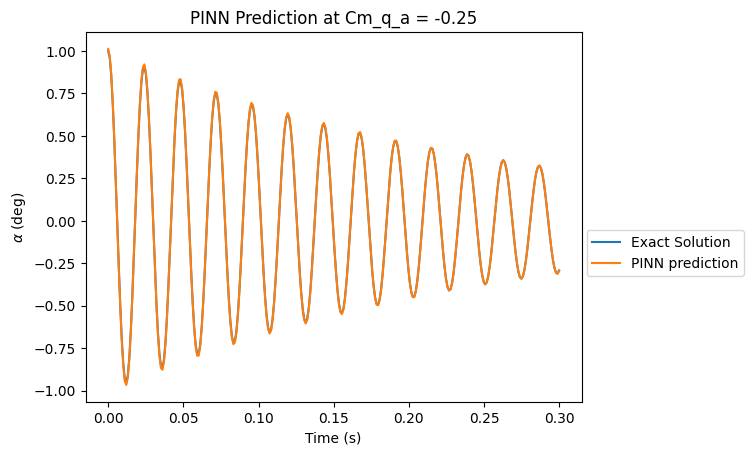

In [78]:
# set up test data
test_cm_q_a = -0.25
test_cm_q_a = test_cm_q_a*torch.ones((300,1))
test_t_data = torch.linspace(0, 0.3, 300).view(-1, 1)
exact_y = oscillator(A, ro, v, s, d, test_cm_q_a, CM_a, I, phi, t).view(-1,1)
# generate prediction using trained PINN model 
with torch.no_grad():
    test_yh = model(test_cm_q_a, test_t_data)*torch.sin(a*test_t_data+b)

# plot the prediction
test = -0.25
plt.plot(test_t_data.numpy(), exact_y.numpy(), label='Exact Solution')
plt.plot(test_t_data.numpy(), test_yh.numpy(), label='PINN prediction')
plt.title(f"PINN Prediction at Cm_q_a = {test}")
plt.xlabel("Time (s)")
plt.ylabel(r'$\alpha$ (deg)')
plt.legend(loc=(1.01,0.34))
plt.show()

In [80]:
squared_error = (test_yh.numpy() - exact_y.numpy()) ** 2
sum_squared_error = np.sum(squared_error)
loss = sum_squared_error / exact_y.numpy().size
print("Mean Squared Error is", loss)

Mean Squared Error is 2.8062338630358377e-05
